In [132]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns 

In [133]:
df = pd.read_csv('/Data Science/DSC/Capstone Project 1/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [72]:
# Check the size of dataframe 

In [134]:
df.shape 

(7043, 21)

In [ ]:
#view the first five rows 

In [135]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
# the detailed info of the first row 

In [136]:
df.iloc[0]

customerID                7590-VHVEG
gender                        Female
SeniorCitizen                      0
Partner                          Yes
Dependents                        No
tenure                             1
PhoneService                      No
MultipleLines       No phone service
InternetService                  DSL
OnlineSecurity                    No
OnlineBackup                     Yes
DeviceProtection                  No
TechSupport                       No
StreamingTV                       No
StreamingMovies                   No
Contract              Month-to-month
PaperlessBilling                 Yes
PaymentMethod       Electronic check
MonthlyCharges                 29.85
TotalCharges                   29.85
Churn                             No
Name: 0, dtype: object

In [ ]:
#check the datatype of each feature

In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [138]:
# check missing values 
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [139]:
# The feature SeniorCitizen indicates whether the customer is a senior citizen or not (1, 0)
# so we need to convert it into catogorical type 
# The feature TotalCharges indicates the total amount charged to the customer
# so we nned to convert it into numerical type 
df['SeniorCitizen'] = df['SeniorCitizen'].astype('category')
df['TotalCharges_num'] = pd.to_numeric(df['TotalCharges'],errors='coerce')

In [ ]:
# double check the data types have been successfully converted 

In [140]:
df.dtypes

customerID            object
gender                object
SeniorCitizen       category
Partner               object
Dependents            object
tenure                 int64
PhoneService          object
MultipleLines         object
InternetService       object
OnlineSecurity        object
OnlineBackup          object
DeviceProtection      object
TechSupport           object
StreamingTV           object
StreamingMovies       object
Contract              object
PaperlessBilling      object
PaymentMethod         object
MonthlyCharges       float64
TotalCharges          object
Churn                 object
TotalCharges_num     float64
dtype: object

In [ ]:
# Check the descriptive statistics for numerical features
# However, the converted TotalCharges generate 11 missing values 
# which means the origical TotalCharges has some invaid values, even though they appear non-missing values 

In [141]:
df.describe()

,tenure,MonthlyCharges,TotalCharges_num
count,7043.000000,7043.000000,7032.000000
mean,32.371149,64.761692,2283.300441
std,24.559481,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3794.737500
max,72.000000,118.750000,8684.800000


In [ ]:
# check missling values again 

In [142]:
for col in df.columns:
    print(col,df[col].isnull().sum())

customerID 0
gender 0
SeniorCitizen 0
Partner 0
Dependents 0
tenure 0
PhoneService 0
MultipleLines 0
InternetService 0
OnlineSecurity 0
OnlineBackup 0
DeviceProtection 0
TechSupport 0
StreamingTV 0
StreamingMovies 0
Contract 0
PaperlessBilling 0
PaymentMethod 0
MonthlyCharges 0
TotalCharges 0
Churn 0
TotalCharges_num 11


In [ ]:
# I discovered that there are 11 observations whose TotalCahrges is string of spaces( missing data)
# we have three strategies to impute missing data 
# 1. for these 11 observations, the value of tunure is 0 
#    for survival analysis, we'll use patial likelihood funciton to find the optimal paramters 
#    We can safely discard them
# 2. We still want to keep these missing data, we impute them with 0 

In [143]:
df[df['tenure'] == 0]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TotalCharges_num
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No,NaN
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No,NaN
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,No,Yes,Yes,Two year,No,Mailed check,80.85,,No,NaN
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No,NaN
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No,NaN
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No,NaN
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No,NaN
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No,NaN
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No,NaN
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,No,Two year,No,Mailed check,73.35,,No,NaN


In [144]:
df[df['TotalCharges_num'].isnull()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TotalCharges_num
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No,NaN
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No,NaN
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,No,Yes,Yes,Two year,No,Mailed check,80.85,,No,NaN
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No,NaN
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No,NaN
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No,NaN
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No,NaN
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No,NaN
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No,NaN
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,No,Two year,No,Mailed check,73.35,,No,NaN


In [145]:
df_1 = df.dropna()

In [146]:
df_1.describe()

,tenure,MonthlyCharges,TotalCharges_num
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441
std,24.545260,30.085974,2266.771362
min,1.000000,18.250000,18.800000
25%,9.000000,35.587500,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.862500,3794.737500
max,72.000000,118.750000,8684.800000


In [147]:
df.loc[df['TotalCharges_num'].isnull(),'TotalCharges_num']  = 0

In [148]:
df[df['tenure'] == 0]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TotalCharges_num
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No,0.0
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No,0.0
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,No,Yes,Yes,Two year,No,Mailed check,80.85,,No,0.0
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No,0.0
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No,0.0
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No,0.0
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No,0.0
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No,0.0
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No,0.0
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,No,Two year,No,Mailed check,73.35,,No,0.0


In [149]:
# The feature TotalCharges_num's missing values have been imputed
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null category
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
TotalCharges_num    7043 non-n

In [ ]:
# So far, we have two dataframes
# df_1: with missing values of TotalCharges_num removed
# df : with missing values of TotalCharges_num filled with zero 
# we focus on df at this point

In [150]:
df.describe()

,tenure,MonthlyCharges,TotalCharges_num
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.734304
std,24.559481,30.090047,2266.794470
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,398.550000
50%,29.000000,70.350000,1394.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


In [151]:
# check the distribution of target variable 
df.Churn.value_counts()/len(df)

No     0.73463
Yes    0.26537
Name: Churn, dtype: float64

In [ ]:
# even though the distribution of TotalCharges is postivaly skewed and the distribution of MonthlyCharges 
# has a great number of obersavtions in the low of monthly charges (not distributed normally), I wouldn't 
# treat them as outliers according the business senece, espetially we will apply survival analysis in this case

Text(0, 0.5, 'Number of Customers')

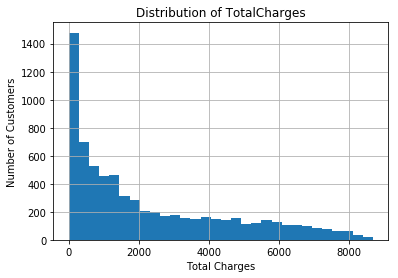

In [152]:
fig = df.TotalCharges_num.hist(bins=30)
fig.set_title('Distribution of TotalCharges')
fig.set_xlabel('Total Charges')
fig.set_ylabel('Number of Customers')

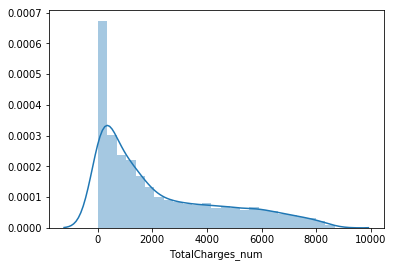

In [153]:
sns.distplot(df.TotalCharges_num)

Text(0, 0.5, 'Number of Customers')

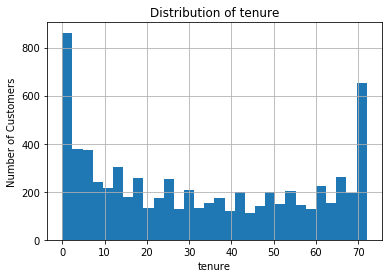

In [41]:
fig = df.tenure.hist(bins=30)
fig.set_title('Distribution of tenure')
fig.set_xlabel('tenure')
fig.set_ylabel('Number of Customers')

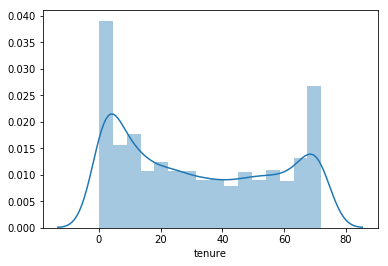

In [154]:
sns.distplot(df.tenure)

Text(0, 0.5, 'Number of Customers')

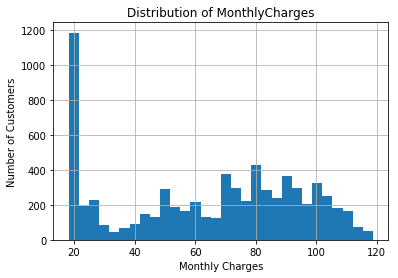

In [40]:
fig = df.MonthlyCharges.hist(bins=30)
fig.set_title('Distribution of MonthlyCharges')
fig.set_xlabel('Monthly Charges')
fig.set_ylabel('Number of Customers')

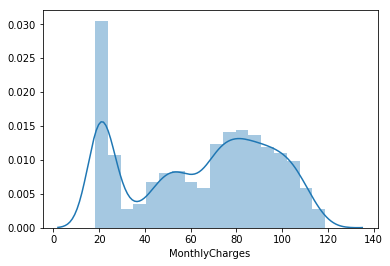

In [155]:
sns.distplot(df.MonthlyCharges)

In [45]:
df.dtypes

customerID            object
gender                object
SeniorCitizen       category
Partner               object
Dependents            object
tenure                 int64
PhoneService          object
MultipleLines         object
InternetService       object
OnlineSecurity        object
OnlineBackup          object
DeviceProtection      object
TechSupport           object
StreamingTV           object
StreamingMovies       object
Contract              object
PaperlessBilling      object
PaymentMethod         object
MonthlyCharges       float64
TotalCharges          object
Churn                 object
TotalCharges_num     float64
dtype: object

In [44]:
# In business sense, we ignore the first feature customerID
# For all other categorical feature,  the largest number of different labels is 4. 
# So the cardinality is not high, so that it is not likely cause overfitting 
# And the relatively rare labels is 9% for 'NO' values of Phoneservice
# 9% for 'No phone service' of MultipleLines
# this also is unlikely to cause overfitting
categorical_num = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 
                   'InternetService','OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                   'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling','PaymentMethod']

for col in categorical_num:
    print(col)
    print(df[col].value_counts()/len(df))
    print('------------------------')

gender
Male      0.504756
Female    0.495244
Name: gender, dtype: float64
------------------------
SeniorCitizen
0    0.837853
1    0.162147
Name: SeniorCitizen, dtype: float64
------------------------
Partner
No     0.516967
Yes    0.483033
Name: Partner, dtype: float64
------------------------
Dependents
No     0.700412
Yes    0.299588
Name: Dependents, dtype: float64
------------------------
PhoneService
Yes    0.903166
No     0.096834
Name: PhoneService, dtype: float64
------------------------
MultipleLines
No                  0.481329
Yes                 0.421837
No phone service    0.096834
Name: MultipleLines, dtype: float64
------------------------
InternetService
Fiber optic    0.439585
DSL            0.343746
No             0.216669
Name: InternetService, dtype: float64
------------------------
OnlineSecurity
No                     0.496663
Yes                    0.286668
No internet service    0.216669
Name: OnlineSecurity, dtype: float64
------------------------
OnlineBacku

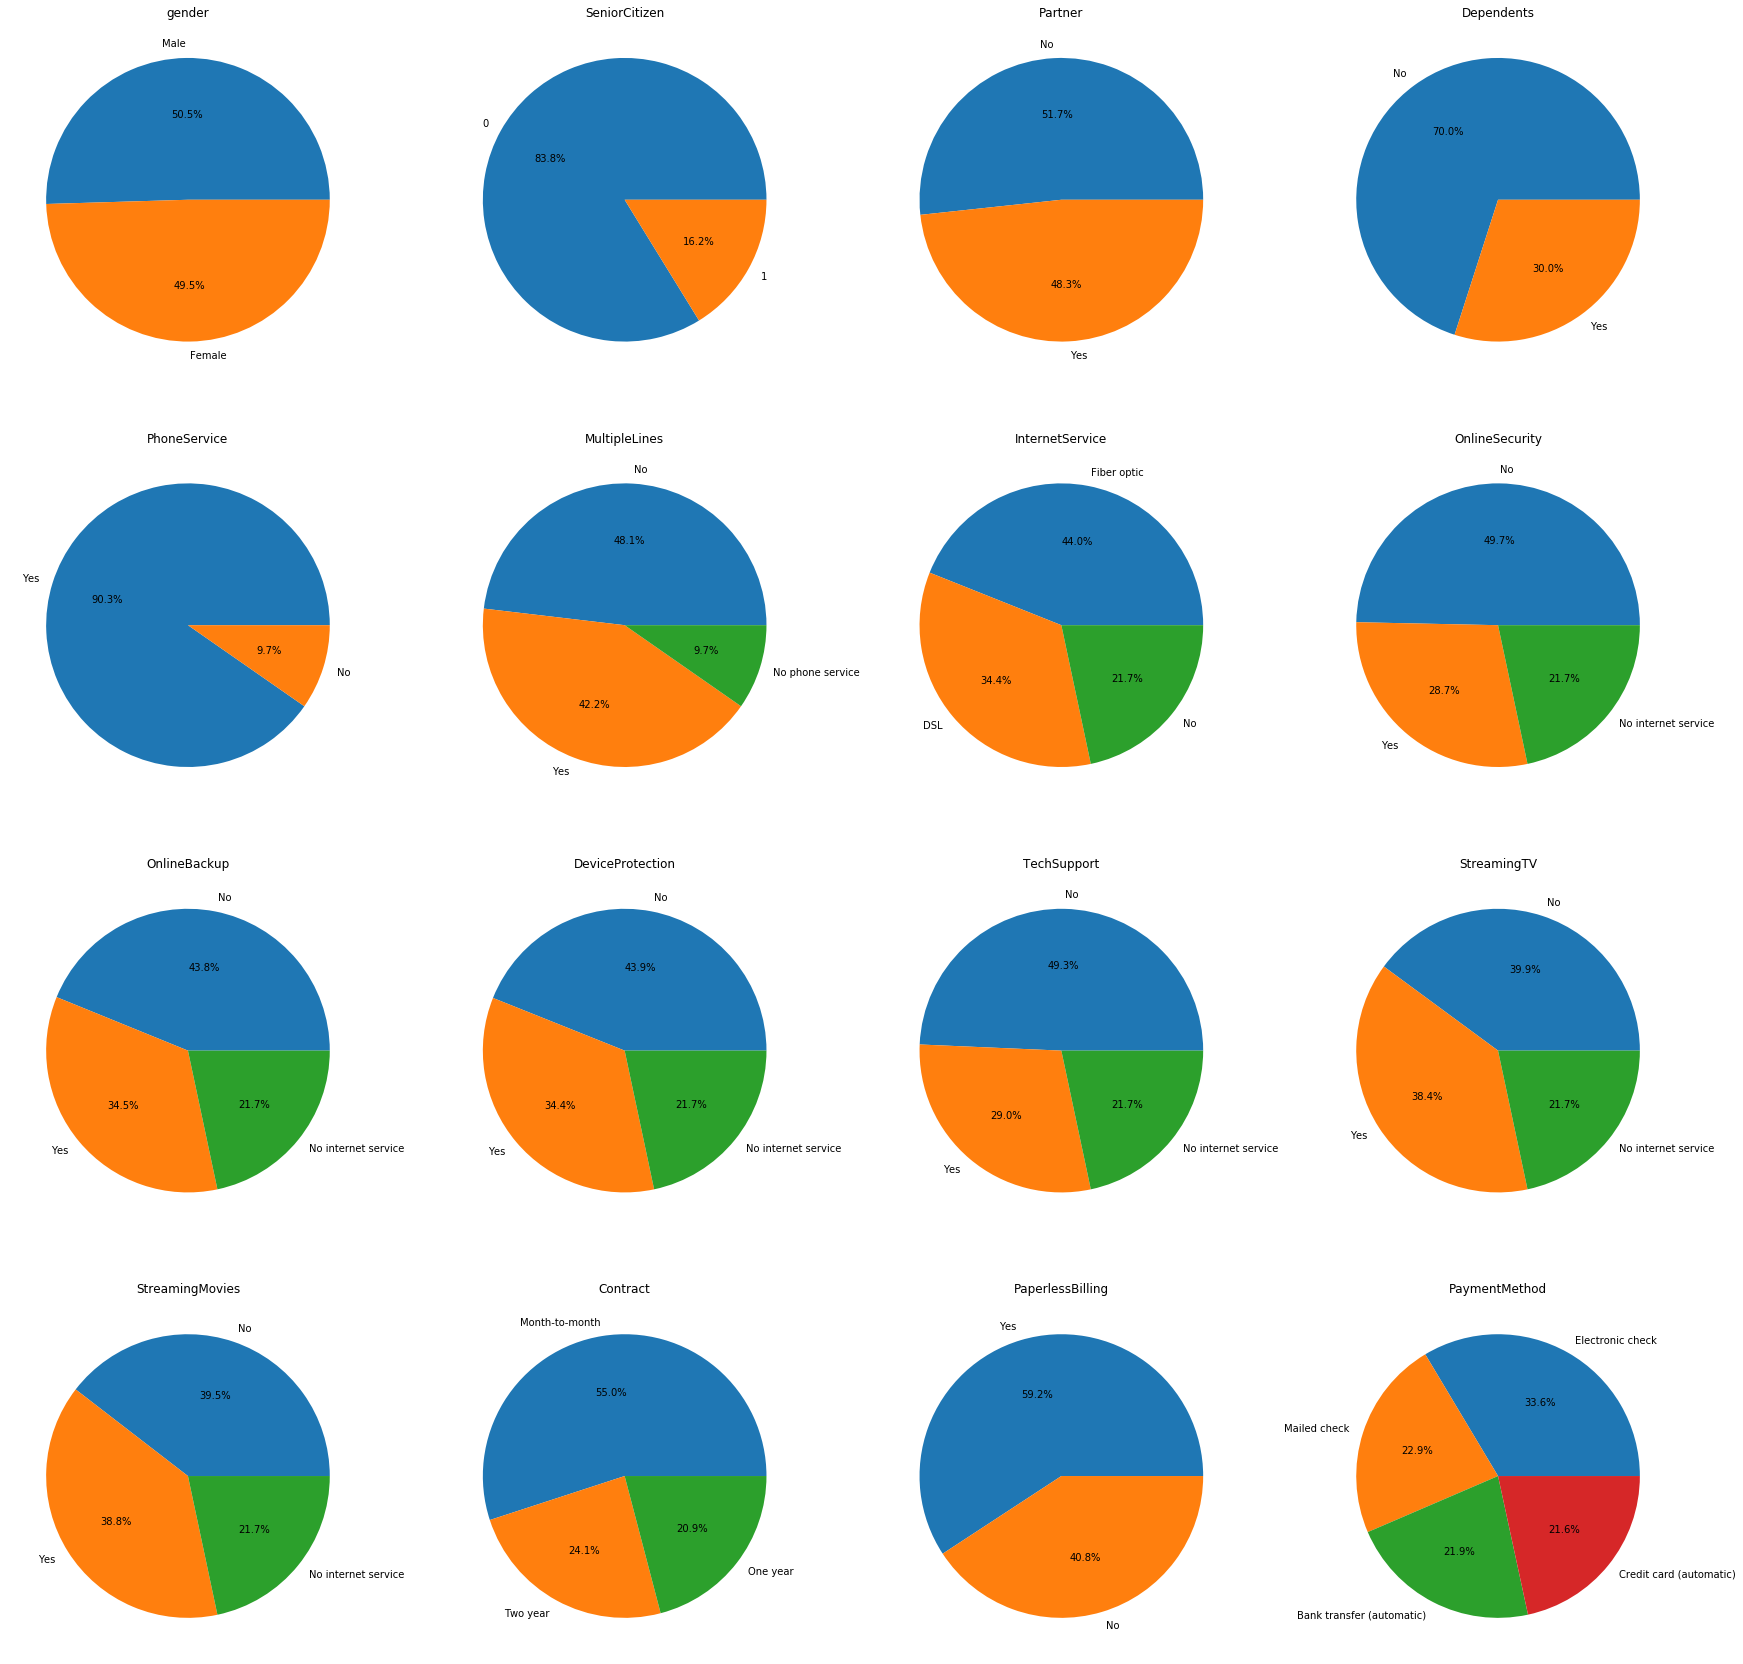

In [125]:
fig, axs = plt.subplots(4,4,figsize=(30,30))
for i, ax in enumerate(axs.reshape(-1)):
    col = categorical_num[i]
    ax.pie(df[col].value_counts(), autopct='%1.1f%%',labels=df[col].value_counts().index)
    ax.set_title(col)